In [3]:
from helper import *
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

In [4]:
fo = pd.ExcelFile('clean-data.xlsx')
df = pd.read_excel(fo, 'Sheet1')

text = df['text']
text_list =  [i.split() for i in text]
print(len(text_list))

2390


In [5]:
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(text_list, min_count=10)
trigram = Phrases(bigram[text_list], min_count=10)

for idx in range(len(text_list)):
    for token in bigram[text_list[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            text_list[idx].append(token)
    for token in trigram[text_list[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            text_list[idx].append(token)

In [6]:
from gensim import corpora, models
# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(text_list)
dictionary.filter_extremes(no_below=5, no_above=0.2)
print(dictionary)

Dictionary(452 unique tokens: ['makna', 'surat', 'manusia', 'kaidah', 'kecil']...)


In [7]:
#build corpus
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]

print(len(doc_term_matrix))
print(doc_term_matrix[100])

tfidf = models.TfidfModel(doc_term_matrix)
corpus_tfidf = tfidf[doc_term_matrix]

2390
[(92, 1), (111, 1)]


In [8]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array
#function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, iterations=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

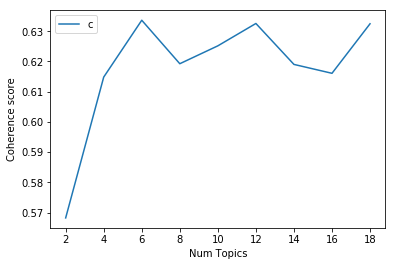

In [9]:
start=2
limit=20
step=2
model_list, coherence_values = compute_coherence_values(dictionary, corpus=corpus_tfidf, 
                                                        texts=text_list, start=start, limit=limit, step=step)
#show graphs
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
from pprint import pprint

model = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)
pprint(model.print_topics())

In [ ]:
model = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=40)

for idx, topic in model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

In [ ]:
import pandas as pd
top_words_per_topic = []
for t in range(model.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in model.show_topic(t, topn = 10)])

#pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv("top_words.csv")
df = pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word','P']).to_csv("top_words2.csv")
print(df)

In [ ]:
import gensim
import pyLDAvis.gensim;pyLDAvis.enable_notebook()

data = pyLDAvis.gensim.prepare(model, corpus_tfidf, dictionary)
print(data)
pyLDAvis.save_html(data, 'lda-gensim-40.html')